In [ ]:
path="/content/amazon product.csv"

IMPORTING LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download NLTK stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

READ THE DATASET

In [ ]:
df = pd.read_csv(path)

In [ ]:
df = df[['reviews.text', 'reviews.rating']]
df.head()

,reviews.text,reviews.rating
0,I initially had trouble deciding between the p...,5.0
1,Allow me to preface this with a little history...,5.0
2,I am enjoying it so far. Great for reading. Ha...,4.0
3,I bought one of the first Paperwhites and have...,5.0
4,I have to say upfront - I don't like coroporat...,5.0


USE STOPWORDS

In [ ]:

default_stopwords = set(stopwords.words('english'))

custom_words = {
    'product', 'amazon', 'item', 'buy', 'purchased', 'purchase',
    'use', 'used', 'using', 'one', 'also', 'thing', 'get', 'got', 'make',
    'the', 'to', 'i', 'a', 'and', 'it', 'is', 'of', 'for', 'this', 'that',
    'you', 'my', 'but', 'have', 'with', 'in', 'as', 'on', 'are', 'so', 'or',
    'they', 'be', 'amazon', 'an'
}
custom_stopwords = default_stopwords.union(custom_words)


In [ ]:
df.dropna(inplace=True)

CREATE SENTIMENT LABELS

In [ ]:
def get_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['sentiment'] = df['reviews.rating'].apply(get_sentiment)

# Check class distribution
df['sentiment'].value_counts()

,count
sentiment,
positive,982
neutral,127
negative,76


CLEAN TEXT

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    filtered_tokens = [word for word in tokens if word not in custom_stopwords]
    return " ".join(filtered_tokens)


# Apply the function to the DataFrame
df['cleaned_text'] = df['reviews.text'].apply(clean_text)

# Preview
df[['reviews.text', 'cleaned_text']].head()


,reviews.text,cleaned_text
0,I initially had trouble deciding between the p...,initially trouble deciding paperwhite voyage r...
1,Allow me to preface this with a little history...,allow preface little history casual reader own...
2,I am enjoying it so far. Great for reading. Ha...,enjoying far great reading original fire since...
3,I bought one of the first Paperwhites and have...,bought first paperwhites pleased constant comp...
4,I have to say upfront - I don't like coroporat...,say upfront dont like coroporate hermetically ...


In [ ]:
from sklearn.utils import resample

# Separate classes
df_pos = df[df.sentiment == 'positive']
df_neu = df[df.sentiment == 'neutral']
df_neg = df[df.sentiment == 'negative']

# Find the max class count
max_count = max(len(df_pos), len(df_neu), len(df_neg))

# Oversample minority classes
df_neu_up = resample(df_neu, replace=True, n_samples=600, random_state=42)
df_neg_up = resample(df_neg, replace=True, n_samples=600, random_state=42)

# Positive class already at max_count, no change
df_balanced = pd.concat([df_pos, df_neu_up, df_neg_up])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


BALANCED THE DATASET

In [ ]:
df_balanced['sentiment'].value_counts()

,count
sentiment,
positive,982
neutral,600
negative,600


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced['cleaned_text'], df_balanced['sentiment'], test_size=0.2, random_state=42, stratify=df_balanced['sentiment']
)

USING TFIDF VECTORIZER

In [ ]:
vectorizer = TfidfVectorizer(stop_words=list(custom_stopwords), ngram_range=(1, 2))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

CALCULATE ACCURACY, CONFUSION MATRIX AND CLASSIFICATION REPORT

In [ ]:
y_pred = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9725400457665904


In [ ]:
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Confusion Matrix:
 [[118   0   2]
 [  0 115   5]
 [  2   3 192]]


In [ ]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

    negative       0.98      0.98      0.98       120
     neutral       0.97      0.96      0.97       120
    positive       0.96      0.97      0.97       197

    accuracy                           0.97       437
   macro avg       0.97      0.97      0.97       437
weighted avg       0.97      0.97      0.97       437



In [ ]:
def predict_sentiment_with_confidence(review_text, model, vectorizer):
    cleaned = clean_text(review_text)
    vectorized = vectorizer.transform([cleaned])
    pred_label = model.predict(vectorized)[0]
    pred_proba = model.predict_proba(vectorized)[0]
    return pred_label, dict(zip(model.classes_, pred_proba))

# Try it
label, scores = predict_sentiment_with_confidence("It is okay, not too good, not too bad.", model, vectorizer)
print("Predicted:", label)
print("Confidence Scores:", scores)

Predicted: neutral
Confidence Scores: {np.str_('negative'): np.float64(0.18958122588267093), np.str_('neutral'): np.float64(0.6360170712114588), np.str_('positive'): np.float64(0.1744017029058716)}


In [ ]:
def predict_sentiment(review_text, model, vectorizer):
    cleaned = clean_text(review_text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    return prediction
print("The product was really good")
print(predict_sentiment("The product was really good", model, vectorizer))
print("The product was very bad.Don't waste money on them")
print(predict_sentiment("The product was very bad.Don't waste money on them.", model, vectorizer))
print(predict_sentiment("It's okay, not too good, not too bad.", model, vectorizer))

The product was really good
positive
The product was very bad.Don't waste money on them
negative
neutral


BAR PLOT

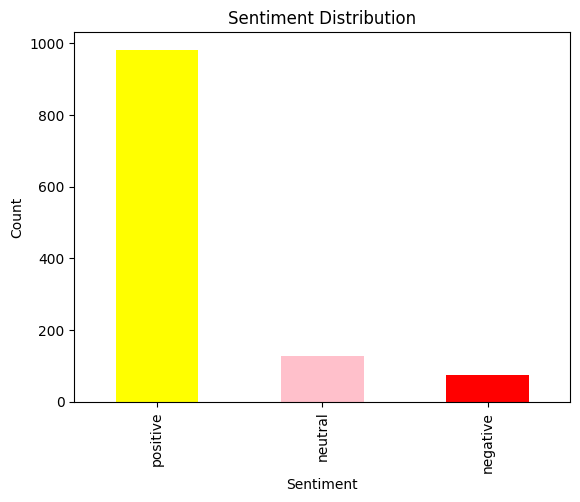

In [ ]:
df['sentiment'].value_counts().plot(kind='bar', color=['yellow', 'pink', 'red'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

PIE CHART

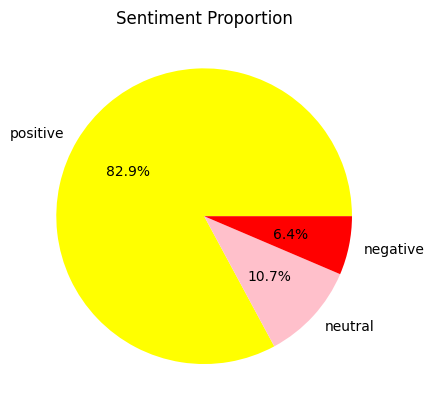

In [ ]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['yellow', 'pink', 'red'])
plt.title("Sentiment Proportion")
plt.ylabel("")
plt.show()

In [ ]:
!pip install gradio


In [ ]:
def predict_sentiment(review_text):
    cleaned = clean_text(review_text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    return prediction


In [ ]:
def predict_sentiment_with_confidence(review_text):
    cleaned = clean_text(review_text)
    vectorized = vectorizer.transform([cleaned])
    pred_label = model.predict(vectorized)[0]
    pred_proba = model.predict_proba(vectorized)[0]
    confidence = dict(zip(model.classes_, pred_proba))
    formatted_scores = "\n".join([f"{cls}: {score:.2f}" for cls, score in confidence.items()])
    return f"Prediction: {pred_label}", formatted_scores


In [ ]:
import gradio as gr

# Gradio interface
interface = gr.Interface(
    fn=predict_sentiment_with_confidence,
    inputs=gr.Textbox(lines=5, label="Enter Review"),
    outputs=[
        gr.Text(label="Sentiment Prediction"),
        gr.Text(label="Confidence Scores")
    ],
    title="Amazon Product Review Sentiment Analyzer",
    description="Enter a review below and the model will predict whether it's Positive, Negative, or Neutral."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d7b076aad61cf9d77f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
